# Simple RMSF b-factor coloring with MDAnalysis 

Import [MDAnalysis](http://mdanalysis.org):

In [1]:
import MDAnalysis as mda
print(mda.__version__)

2.7.0


For pretty plots we use [matplotlib](http://matplotlib.org) and [seaborn](https://stanford.edu/~mwaskom/software/seaborn/) (as shown in [Making better plots](http://nbviewer.jupyter.org/github/Becksteinlab/making-prettier-plots/blob/master/Making%20better%20plots.ipynb)):

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('ticks')

To allows any plots generated by 'matplotlib' to be shown immediately below the cell that created them, without needing to call 'plt.show()':

In [3]:
%matplotlib inline

In [4]:
import numpy as np

Test data for the example:

In [5]:
from MDAnalysis.tests.datafiles import PSF, DCD

Create the universe and an AtomGroup with the protein atoms, which we name `protein`:

In [6]:
u = mda.Universe(PSF, DCD)
protein = u.select_atoms("protein")

## Calculate the all-atom RMSF

There exists a convenient analysis class [MDAnalysis.analysis.rms.RMSF](http://pythonhosted.org/MDAnalysis/documentation_pages/analysis/rms.html#MDAnalysis.analysis.rms.RMSF) to calculate the root mean square fluctuations for any AtomGroup. We import the `rms` module first:

In [5]:
from MDAnalysis.analysis import rms

Set up calculation of the root mean square fluctuations
$$
\rho_i = \sqrt{\Big\langle (\mathbf{r}_{i} - \langle \mathbf{r}_{i} \rangle)^2 \Big\rangle}
$$
for each atom $i$ and run it:

**NOTE: This trajectory is already made whole and rms-fitted to the average structure.**
- **If your structure is broken across PBC then you need to make it whole.**
- **If your trajectory is not centered and fitted to an average then you have to do this first**, otherwise calculating fluctuations does not make sense.

(These steps are omitted because I didn't have time to include them, see for more help the docs for [analysis.rms.RMSF](https://www.mdanalysis.org/mdanalysis/documentation_pages/analysis/rms.html#MDAnalysis.analysis.rms.RMSF))

In [14]:
R = rms.RMSF(protein)
R.run()

The RMSF is stored in the attribute `rmsf` as a numpy array:

In [15]:
R.rmsf

array([1.52679958, 1.61347775, 1.58422195, ..., 2.13808737, 2.29449016,
       2.18431388])

### Plotting the per-atom RMSF

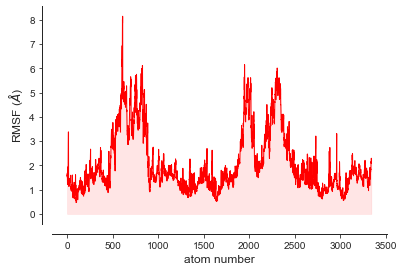

In [18]:
ax = plt.subplot(111)
ax.plot(protein.atoms.ids, R.rmsf, 'r-', linewidth=1)
ax.fill_between(protein.atoms.ids, R.rmsf, color="red", alpha=0.1)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("atom number")
ax.set_ylabel(r"RMSF ($\AA$)");

### Plotting the C$_\alpha$ RMSF only 

Plot the RMSF of the C$_\alpha$ atoms as a function of residue number: To do that, we have to pick out the C$_\alpha$ atoms first as well as the RMSF data that belongs to the C$_\alpha$ atoms:

In [11]:
CA = protein.select_atoms("name CA")
CA_rmsf = R.rmsf[np.in1d(protein.ids, CA.ids)]

(The `np.in1d(protein.ids, CA.ids)` is advanced use of array indexing: It creates a boolean mask that is `True` for any atom index in `protein` that is in the list of atom indices of the `CA` selection. In this way we can pick out exactly the data from `R.rmsf`, which is ordered according to the atoms in `protein`.)

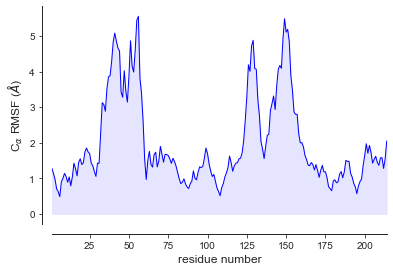

In [17]:
ax = plt.subplot(111)
ax.plot(CA.resids, CA_rmsf, 'b-', linewidth=1)
ax.fill_between(CA.resids, CA_rmsf, color="blue", alpha=0.1)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("residue number")
ax.set_ylabel(r"C$_\alpha$ RMSF ($\AA$)")
ax.set_xlim(CA.resids.min(), CA.resids.max());

_Note_: Instead of getting the C-alpha data from the all-atom data one could have also simply run the analysis on the `CA` atoms only 
```python
R_CA = rms.RMSF(CA)
R_CA.run()
```
and then directly plotted.

## Create a PDB file with the b-factor colored by RMSF 

Color each residue by the all-atom RMSF: Add a `tempfactor` property to the atoms and then we can simply set the `tempfactors` of all atoms in the `protein` AtomGroup:

In [19]:
# dynamically add new attributes
# ('tempfactors' is pre-defined and filled with zeros as default values)
u.add_TopologyAttr('tempfactors')

Now we can fill the `tempfactors` with the RMSF values:

In [20]:
protein.tempfactors = R.rmsf

Finally, write out a PDB file from the `protein` AtomGroup; here I want this to be the *last* frame of the trajectory so I make sure to advance to the last frame first:

In [21]:
u.trajectory[-1]   # jump to last frame

< Timestep 97 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

Then write the atoms in the `protein` AtomGroup to a PDF file:

In [22]:
protein.write("protein_with_bfactors.pdb")

/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))


(These warnings are harmless – they are just saying that PDB files have many additional properties that we didn't specify and they are set to default values. We could have also added the `occupancies` and then set them to another value of interest.)

I rendered the protein in Chimera (follow the [Image Tutorial: B-Factor Coloring](https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/bfactor.html) — note that tempfactors are listed as the attributed *bfactors* in Tools/Render by Attribute):
```bash
chimera protein_with_bfactors.pdb
```
and saved the image to a file `protein-bfactor.png`:

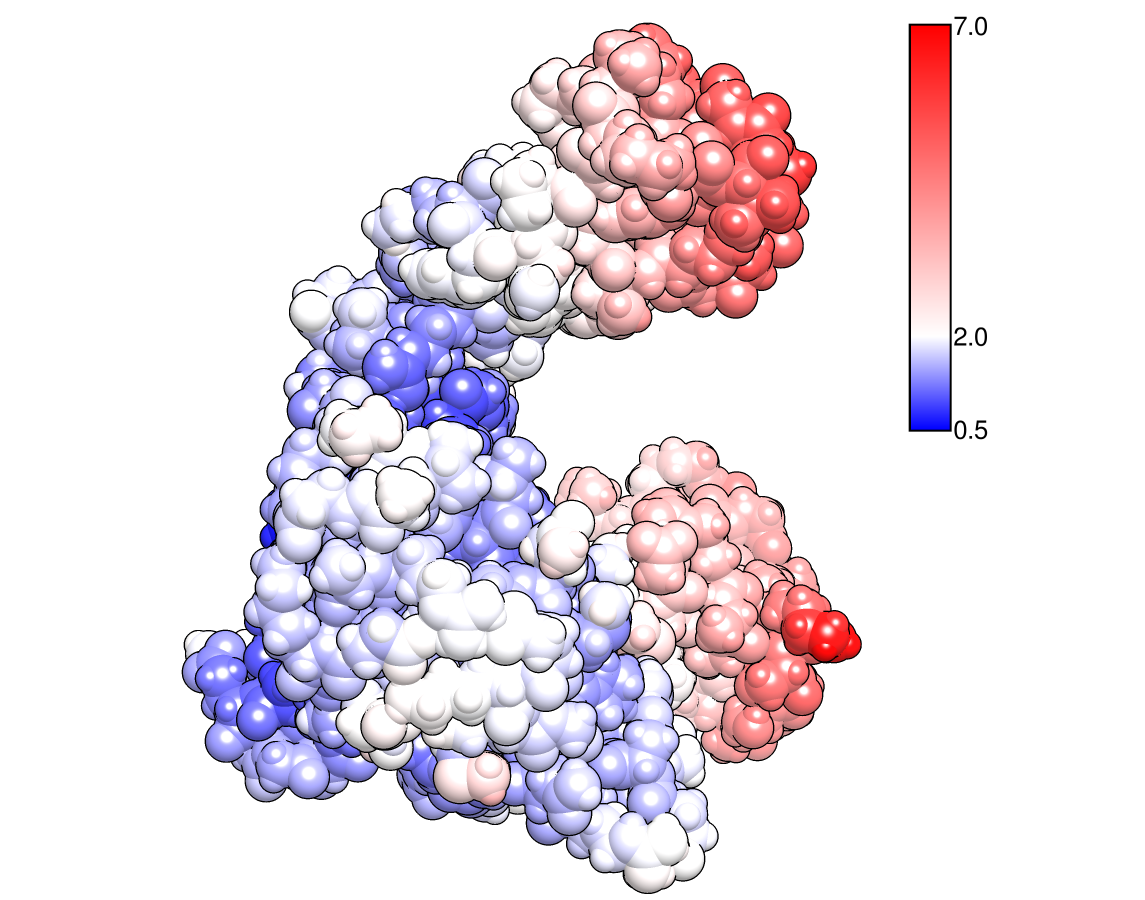

In [24]:
from IPython.display import Image
Image(filename="protein-bfactor.png")

(Note that in this example we calculated the RMSF over a trajectory that shows a conformational change, namely an opening of the AdK molecule. Therefore, the largest RMSF is in the parts that move. However, that really invalidates the RMSF, which is defined as an *equilibrium average*. The test trajectory is not in equilibrium and so our calculated RMSF is not meaningful. You shouldn't be calculating an RMSF over a process that is not sampling equilibrium but for the sake of the tutorial we did it for illustrative purposes.)